# Seismic data spectral analysis and cross-correlation with CuPy

- author: Roméo Courbis (romeo.courbis@sisprobe.com)
- date: 28/02/2022

In [1]:
import numpy as np
import obspy
import time
from sisdailydatah5 import SisDailyDatah5
import pandas as pd
import numpy as np
import cupy as cp
from numba import cuda
from scipy import fft
from cupyx.scipy import fft as fft_gpu
from scipy import signal
from cusignal.spectral_analysis.spectral import spectrogram

C:\Users\courbisr\Miniconda3\envs\pysis3\lib\site-packages\cupy\_environment.py:206: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  'CUDA path could not be detected.'


In [2]:
%matplotlib inline
from matplotlib import dates as mdates
from matplotlib import pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

C:\Users\courbisr\Miniconda3\envs\pysis3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  """


In [3]:
cuda.detect()

Found 1 CUDA devices
id 0    b'NVIDIA GeForce GTX 1050'                              [SUPPORTED]
                      Compute Capability: 6.1
                           PCI Device ID: 0
                              PCI Bus ID: 1
                                Watchdog: Enabled
                            Compute Mode: WDDM
             FP32/FP64 Performance Ratio: 32
Summary:
	1/1 devices are supported


True

## Routines

- A seismic data reader with controllable precision
- An automatic date ticker

In [29]:
def read_daily_h5(daily_h5, station_file, dtype=np.float32):
    """
    """
    stations = pd.read_csv(station_file, sep=" ", header=None)
    sd = SisDailyDatah5(daily_h5)
    stream = sd.get_stream()
    stream = stream.select(channel='Z')
    stream = stream.decimate(5)
    print(stream)
    t = stream[0].times() / 24 / 3600 + stream[0].stats.starttime.matplotlib_date
    x = [trace.data.astype(dtype) for trace in stream]
    x = np.array([trace / np.linalg.norm(trace) for trace in x])
    kna = [trace.id for trace in stream]
    lon = [stations.loc[stations[2] == n, 5] for n in kna]
    lat = [stations.loc[stations[2] == n, 4] for n in kna]
    return t, x, (kna, lon, lat)

In [30]:
def dateticks(axis):
    """Add date ticks to given axes.
    
    Arguments
    ---------
    axis: matplotlib.pyplot.Axis
        The axis of a given Axes (e.g. `ax.xaxis` or `ax.yaxis`).
    """
    locator = mdates.AutoDateLocator()
    formatter = mdates.ConciseDateFormatter(locator)
    axis.set_major_locator(locator)
    axis.set_major_formatter(formatter)
    pass

## Read and show seismogram

- A seismic data reader with controllable precision
- An automatic date ticker

In [31]:
# t, x, stations = read_seismograms('data-usarray-1.5Hz/*quiet*')
data_path = "F:\\2021_MOANDA\\PTA_MONITORING\\OUTPUTS\\data_125.0hz\\daily\\PA1\\2021\\day_309.h5"
station_file = 'F:\\2021_MOANDA\\PTA_MONITORING\\station_coords\\stations_units_2021_MOANDA_POINT_A_DEPLOYED.txt'
t, x, (names, lon, lat) = read_daily_h5(data_path, station_file)
# x = x[::5]
# names = names[::5]
# lon = lon[::5]
# lat = lat[::5]
print('Loaded {} seismograms with {} samples each.'.format(*x.shape))

3 Trace(s) in Stream:
PA1.54059.00.Z | 2021-11-05T00:00:00.000000Z - 2021-11-05T23:59:59.960000Z | 25.0 Hz, 2160000 samples
PA1.54062.00.Z | 2021-11-05T00:00:00.000000Z - 2021-11-05T23:59:59.960000Z | 25.0 Hz, 2160000 samples
PA1.54064.00.Z | 2021-11-05T00:00:00.000000Z - 2021-11-05T23:59:59.960000Z | 25.0 Hz, 2160000 samples
Loaded 3 seismograms with 2160000 samples each.


In [22]:
print(type(x))
print(x.shape)
print(x.nbytes/1e6)

<class 'numpy.ndarray'>
(3, 10800000)
129.6


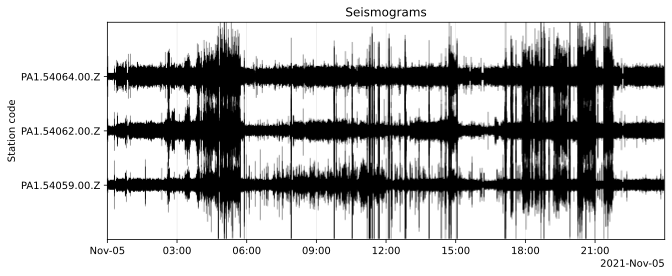

In [32]:
fig, ax = plt.subplots(1, figsize=(10, 4))
for i, trace in enumerate(x):
    trace /= .01 * np.linalg.norm(trace)
    ax.plot(t, trace + i, lw=.2, c='k', rasterized=True)

ax.set_xlim(t[[0, -1]])
ax.grid(lw=.2)
ax.set_yticks(range(len(names)))
ax.set_yticklabels(names)
ax.set_ylim([-1, len(names)])
dateticks(ax.xaxis)
ax.set_ylabel('Station code')
ax.set_title('Seismograms');

## Calculate a spectrogram

Two functions, one with `scipy` based on CPU, the other one with `cupy` with GPU. 


In [33]:
def spectrogram_with_sp(t, x, window_duration=10, whiten=False):
    """Calculate a spectrogram with numpy."""
    fs = 1 / (t[1] - t[0]) / 24 / 3600
    nbin = int(window_duration * fs)
    overlap = 3 * (nbin // 4)
    step = nbin // 4
    nfft = 2 * nbin + 1
    _, _, stft = signal.stft(x, nperseg=nbin, noverlap=overlap, nfft=nfft, padded=False, boundary=None)
    if whiten is True:
        stft /= (np.abs(stft) + 1e-4)
    return np.transpose(stft, [0, 2, 1])

In [34]:
def spectrogram_with_cp(t, x, window_duration=10, whiten=False):
    """Calculate a spectrogram with cupy."""
    fs = 1 / (t[1] - t[0]) / 24 / 3600
    nbin = int(window_duration * fs)
    overlap = 3 * (nbin // 4)
    step = nbin // 4
    nfft = 2 * nbin + 1
#     _, _, stft = fft_gpu.fft(x, nperseg=nbin, noverlap=overlap, nfft=nfft, padded=False, boundary=None)
    _, _, stft = spectrogram(x, fs=125.0, nperseg=nbin, noverlap=overlap, nfft=nfft)
    if whiten is True:
        stft /= (np.abs(stft) + 1e-4)
    return cp.transpose(stft, [0, 2, 1])

In [35]:
window_duration = 60*60  # seconds

In [41]:
%%time
# x_gpu = cp.asarray(x)
xfft_cp = spectrogram_with_cp(t, x, window_duration)

Wall time: 590 ms


In [42]:
%%time
xfft_sp = spectrogram_with_sp(t, x, window_duration)

Wall time: 5.62 s


In [40]:
xfft_cp = cp.asarray(xfft_sp)

In [ ]:
fig, ax = plt.subplots(3, figsize=(10, 6), sharex=True, constrained_layout=True)

station_id = 1
fs = 1 / (t[1] - t[0]) / 24 / 3600
img_kw = dict(aspect='auto', origin='lower', cmap='magma', extent=[t[0], t[-1], fs / xfft_cp.shape[2], fs])

ax[0].plot(t, x[station_id], rasterized=True, lw=.2, c='k')
img1 = ax[1].imshow(np.log(np.abs(xfft_cp[station_id].get() + 1e-10)).T, **img_kw)
img2 = ax[2].imshow(np.log(np.abs(xfft_sp[station_id] + 1e-10)).T, **img_kw)

# Cosmetics
for a, img in zip(ax[1:], [img1, img2]):
    plt.colorbar(img, ax=a)
    a.set_yscale('log')
    a.set_ylabel('Frequency (Hz)')

ax[0].grid(lw=.2)
ax[0].set_ylabel('Ground motion')
ax[0].set_title('Seismogram from {}'.format(names[station_id]))
ax[1].set_title('Spectrogram with Cupy')
ax[2].set_title('Spectrogram with Scipy')
dateticks(ax[2].xaxis)

## Going further with cross-correlation

In [44]:
def xcorr_with_cp(stft):
    """Calculate cross-correlation from spectrogram."""
    cs = cp.einsum('ink,jnk->ijnk', stft, cp.conj(stft))
    csd = cp.sum(cs, axis=2)
    xcorr = cp.fft.fftshift(cp.fft.irfft(csd), axes=-1)

In [45]:
def xcorr_with_sp(stft):
    """Calculate cross-correlation from spectrogram."""
    cs = np.einsum('ink,jnk->ijnk', stft, np.conj(stft))
    csd = np.sum(cs, axis=2)
    xcorr = np.fft.fftshift(np.fft.irfft(csd), axes=-1)
    return xcorr

In [ ]:
# %%timeit
# xcorr_tf = xcorr_with_tf(xfft_tf)
# print(xcorr_tf.shape)

In [48]:
%%time

xcorr_cp = xcorr_with_cp(xfft_cp)

Wall time: 1.98 ms


In [47]:
%%time
xcorr_sp = xcorr_with_sp(xfft_sp)

Wall time: 991 ms
